# Layered approach for Neural Networks

The goal of this homework is simple, yet an actual implementation may take some time. We are going to write an Artificial Neural Network (almost) from scratch. The software design of was heavily inspired by [Torch](http://torch.ch).

This homework requires sending two files, please do not forget to include all the files when submitting to Canvas. The list of files:
- Main.ipynb (this notebook)
- Modules.ipynb

In [1]:
import os
import sys
import time
import copy

import numpy as np
import progressbar

from sklearn.datasets import fetch_mldata
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython import display

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Set style

In [2]:
sns.set(style="whitegrid", font_scale=1.3)
matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True
matplotlib.rcParams["figure.figsize"] = (10, 8)

# Framework

Implement everything in `Modules.ipynb`. Please read all the comments thoughtfully and try not to change the prototypes.

Do not forget, that each module should return AND store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored.

In [3]:
%run ModulesMaster.ipynb

`Modules` notebook provides all the necessary layers and criterions but is does not have optimization rotuine. 

There is a reason for that. Layers and Sequential container should be able to calculate gradient for you but there might be different ways of further usage os this gradients, i.e., different optimization algorithms.

Here you're asked to implement few of them.

Basic gradient descent with simple momentum is implemented for you.

In [4]:
def sgd_momentum(x, dx, config, state):
    
    """
    Example implementation of sgd with momentum 
    just to show an example how to store old grad in state.
    
    config:
        - momentum
        - learning_rate
    state:
        - v
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('v', {})
    config.setdefault("momentum", 0.9)
    config.setdefault("learning_rate", 0.1)
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            
            v = state['v'].setdefault(i, np.zeros_like(cur_dx))
            
            np.subtract(config['momentum'] * v, config['learning_rate'] * cur_dx, out = v)
            
            cur_x += v
            i += 1

## TASK 1: Nesterov momentum

Although gradient descent with momentum is good it still has first order of convergence. One can further improve it and take it to the second level of convergence by using ***Nesterov momentum*** instead of simple momentum.

In [5]:
def nesterov(x, dx, config, state):
    """
    Nesterov accelerated gradient with momentum
    """
    # reformulation can be taken from
    # http://cs231n.github.io/neural-networks-3/#sgd
    
    #==================================================#
    
    state.setdefault('v', {})
    config.setdefault("momentum", 0.9)
    config.setdefault("learning_rate", 0.1)
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x, dx): 
        for cur_x, cur_dx in zip(cur_layer_x, cur_layer_dx):
            
            v = state['v'].setdefault(i, np.zeros_like(cur_dx))
            v_prev = copy.deepcopy(v)
            
            np.subtract(config['momentum'] * v, config['learning_rate'] * cur_dx, out = v)
            
            cur_x += - config['momentum'] * v_prev + (1 + config['momentum']) * v
            
            i += 1
    
    #==================================================#

## TASK 2 (optional): Adam

One can improve simple momentum method in different way: automatic scheduling of learning rate. It leads to the `Adam` optimization algorithm. This algorithm is considered as state-of-the-art for deep learning.

In [6]:
def adam(x, dx, config, state):
    """
    Adam optimization method.
    Reference paper:
    Kingma, Diederik, and Jimmy Ba (2014): Adam: A Method for Stochastic Optimization.
    https://arxiv.org/abs/1412.6980
    """
    # http://sebastianruder.com/optimizing-gradient-descent/index.html#adam
    
    #==================================================#
    
    state.setdefault("v", {})
    state.setdefault("g", {})
    config.setdefault("beta1", 0.9)
    config.setdefault("beta2", 0.999)
    config.setdefault("eps", 1e-8)
    config.setdefault("learning_rate", 0.001)
    
    state.setdefault("iter", 0.)
    state["iter"] += 1.
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x, dx): 
        for cur_x, cur_dx in zip(cur_layer_x, cur_layer_dx):
            
            v = state["v"].setdefault(i, np.zeros_like(cur_dx))
            g = state["g"].setdefault(i, np.zeros_like(cur_dx))
            
            np.add(config['beta1'] * v, (1. - config['beta1']) * cur_dx, out = v)
            np.add(config['beta2'] * g, (1. - config['beta2']) * cur_dx * cur_dx, out = g)

            alpha = config['learning_rate'] * np.sqrt(1. - config['beta2'] ** state["iter"]) / (1. - config['beta1'] ** state["iter"])
            
            cur_x -= alpha * v / (np.sqrt(g) + config["eps"])
            
            i += 1
    
    #==================================================#

# Toy example

Use this example to debug your `Modules` code.

Start with logistic regression and then test other layers. This code is provided for you to test the layers.

## Data generation

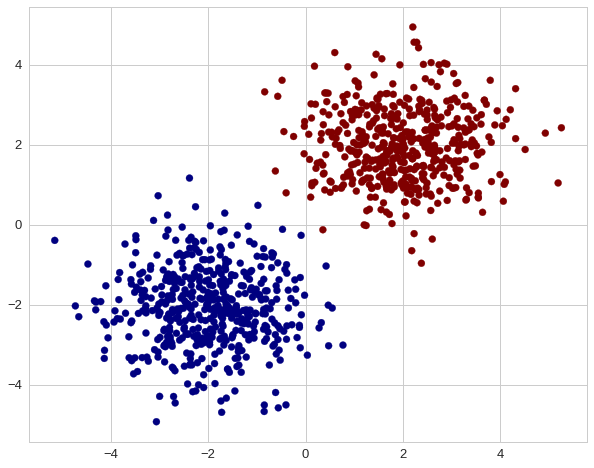

In [7]:
# number of points for each class
N = 500
# generate gaussian clusters
X1 = np.random.randn(N, 2) + np.array([2, 2])
X2 = np.random.randn(N, 2) + np.array([-2, -2])
X = np.vstack([X1, X2])
# generate labels
Y = np.concatenate([np.ones(N), np.zeros(N)])[:, None]
Y = np.hstack([Y, 1 - Y])
# draw
plt.scatter(X[:, 0],X[:, 1], 
            c = Y[:, 0], cmap="jet");
xlims = plt.gca().get_xlim()
ylims = plt.gca().get_xlim()

## Model definition

 Define a **logistic regression** for debugging.

In [8]:
net = Sequential()
net.add(Linear(2, 2))
net.add(SoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(SoftMax())

# criterion = ClassNLLCriterion()

# print(net)

Linear 2 -> 2
SoftMax



Start with `batch_size` = 1000 to make sure every step lowers the loss, then try stochastic version.

In [9]:
# Optimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Training params
n_epoch = 100
batch_size = 1000

Let's also define batch generator

In [10]:
def get_batches(dataset, batch_size):
    
    X, y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        
        batch_idx = indices[start : start + batch_size]
    
        yield X[batch_idx], y[batch_idx]

## Train

Basic training loop. Examine it.

Current loss: 0.002289


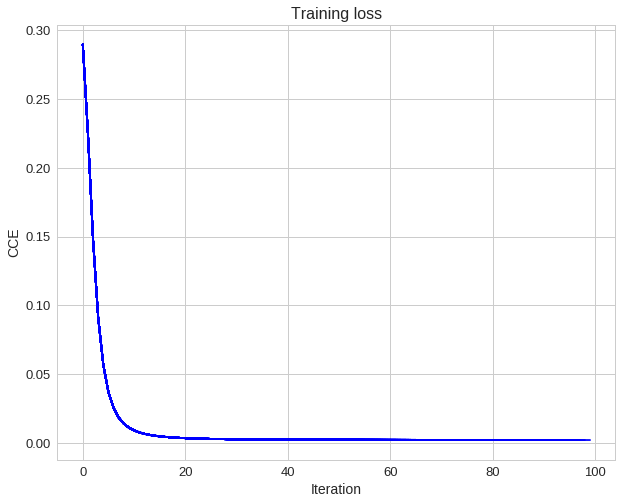

In [11]:
loss_history = []
state_hist = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        # zero all params
        net.zeroGradParameters()
        
        # forward pass
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # backward pass
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)
        # keep track of the step to see its progress later
        state_hist.append(copy.deepcopy(optimizer_state["v"]))
        # store history
        loss_history.append(loss)

    # sisualize training loss
    display.clear_output(wait=True)
        
    plt.title("Training loss", fontsize=16)
    plt.xlabel("Iteration", fontsize=14)
    plt.ylabel("CCE", fontsize=14)
    plt.plot(loss_history, 'b');
    
    print('Current loss: %f' % loss)    

Frobebius norm of Jacobian of 1 layer weight matrix at each step.

As one can notice the norm of the gradients becomes smaller and smaller as learning goes forward. It means that we're appoaching extrema point which is good.

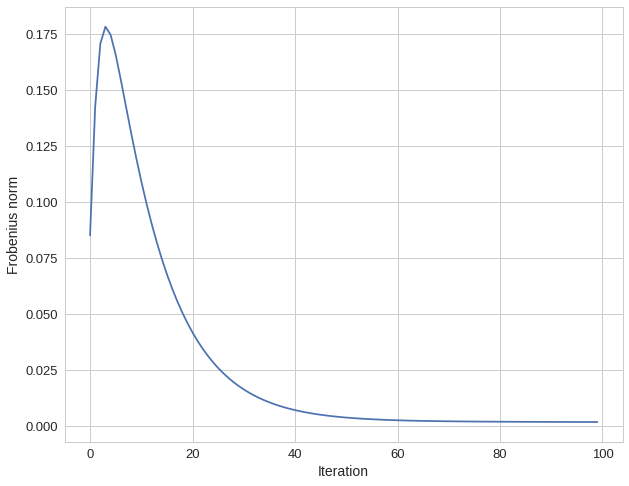

In [12]:
plt.plot(np.linalg.norm(np.array(list(map(lambda x: x[0], state_hist))), ord="fro", axis=(1, 2)))
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Frobenius norm", fontsize=14);

Let's also draw decision surface

In [13]:
xx, yy = np.meshgrid(np.linspace(*xlims, num=100), 
                     np.linspace(*ylims, num=100))

In [14]:
X_test = np.hstack((xx.flatten().reshape(-1, 1), yy.flatten().reshape(-1, 1)))

In [15]:
Z = net.updateOutput(X_test)
Z = np.argmax(Z, axis=1)

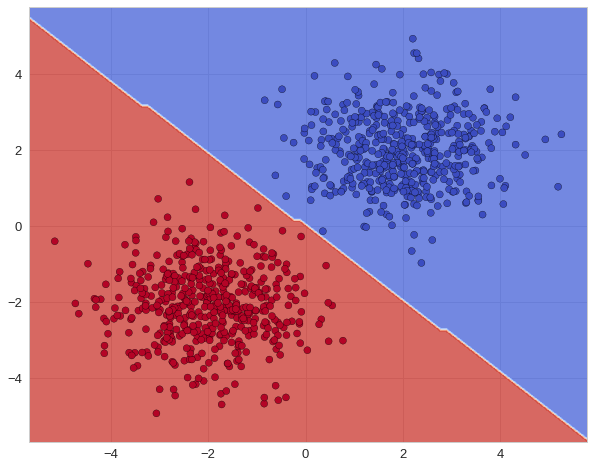

In [16]:
plt.contourf(xx, yy, Z.reshape(xx.shape), cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=np.argmax(Y, axis=1), cmap=plt.cm.coolwarm, edgecolors="k")
plt.xlim(xlims)
plt.ylim(ylims)
plt.show()

# MNIST digit classification 

Let's define a Keras-like interface to make training as easy and comfortable as possible. You do not need to change anything here.

In [17]:
class ModelTorch(Sequential):
    
    def __init__(self):
        super(ModelTorch, self).__init__()
    
    def predict_proba(self, X):
        """
        Return probability distribution over classes 
        for each input object in X
        
        Args:
            X (ndarray): array of objects
        
        Return:
            y (ndarray): array of distribution 
                         of the same length as X
        """
        self._set_evaluation_mode()
        return self.forward(X)
    
    def predict(self, X):
        """
        Return class label
        for each input object in X
        
        Args:
            X (ndarray): array of objects
        
        Return:
            y (ndarray): array class labels 
                         of the same length as X
        """
        self._set_evaluation_mode()
        return np.argmax(self.predict_proba(X), axis=1)
    
    def compile(self, loss, optimizer, optimizer_config={}, accuracy=False):
        """
        Build a model. In fact this method just a wrapper
        to store loss function and optimizer
        
        Args:
            loss (Criterion): instance of Criterion class child 
                              implementing particular loss function
            optimizer (callable): function implementing optimizer
            opt_config (dict): configuration for optimizer
            accuracy (bool): whether to trace accuracy of not
        
        Return:
            None
        """
        self.loss = loss
        self.optimizer = optimizer
        self.optimizer_config = optimizer_config
        self.accuracy = accuracy
    
    def fit(self, X, y, batch_size=128, epochs=10, shuffle=True, iteration_hist=False, validation_data=(None, None)):
        """
        Train a model
        
        Args:
            X (ndarray): array of train objects
            y (ndarray): array train class labels of the same length as X
            batch_size (int): size of batch during training
            epochs (int): number of training epochs
            shuffle (bool): whether to shuffle data during training or not
            iteration_hist (hist): if True then history will store metrics 
                                   after each step of gradient descent;
                                   otherwise epoch-based metrics are returned
            validation_data (tuple): (X, y) tuple contatining validation data
        
        Return:
            history (dict): dict which contains all the metrics traced over the training
        """
        self._set_training_mode()
        
        if self.accuracy:
            history = {"loss": [], "val_loss": [], "acc": [], "val_acc": [], "time": None}
        else:
            history = {"loss": [], "val_loss": [], "time": None}
        optimizer_state = {}
        
        X_test, y_test = validation_data
        
        start_time = time.time()
        
        for i in range(epochs):
            
            progress = progressbar.ProgressBar(max_value=X.shape[0], 
                                               widgets=["{:<11}".format(str(i + 1) + " Epoch"), 
                                                        progressbar.Percentage(), " ", 
                                                        progressbar.SimpleProgress('(%s)' % \
                                                                            progressbar.widgets.SimpleProgress.DEFAULT_FORMAT), " ", 
                                                        progressbar.Bar(), "\t", 
                                                        progressbar.ETA()])
            progress._MINIMUM_UPDATE_INTERVAL = 0.001
            
            loss_history = []
            if self.accuracy:
                acc_history = []
            
            for X_batch, y_batch in self._get_batches((X, y), batch_size, shuffle):

                # init gradients with zeros
                self.zeroGradParameters()

                # forward pass
                preds = self.forward(X_batch)
                loss = self.loss.forward(preds, y_batch)
                if self.accuracy:
                    acc = accuracy_score(np.argmax(y_batch, axis=1), np.argmax(preds, axis=1))

                # Backward pass
                dp = self.loss.backward(preds, y_batch)
                self.backward(X_batch, dp)

                # update weights with chosen optimizer
                self.optimizer(self.getParameters(), 
                               self.getGradParameters(), 
                               self.optimizer_config.copy(),
                               optimizer_state)
                
                # update progress bar
                progress.update(progress.value + X_batch.shape[0])
                
                # keep track of a history batch by batch
                loss_history.append(loss)
                if self.accuracy:
                    acc_history.append(acc)

            # record history
            if iteration_hist:
                history["loss"].extend(loss_history)
                if self.accuracy:
                    history["acc"].extend(acc_history)
            else:
                history["loss"].append(np.mean(loss_history))
                if self.accuracy:
                    history["acc"].append(np.mean(acc_history))
            
            # check validation quality
            if X_test is not None:
                self._set_evaluation_mode()
                preds = self.forward(X_test)
                history["val_loss"].append(self.loss.forward(preds, y_test))
                if self.accuracy:
                    history["val_acc"].append(accuracy_score(np.argmax(y_test, axis=1), np.argmax(preds, axis=1)))
                self._set_training_mode()
            
            progress.finish()
        
        end_time = time.time()
        history["time"] = end_time - start_time
        
        return history
    
    def _get_batches(self, dataset, batch_size, shuffle=True):
        """
        Helper function that yields data via generator
        
        Args:
            dataset (tuple): (X, y) data
            batch_size (int): size of batch to return at each step
            shuffle (bool): whether to shuffle data after every epoch
        
        Return:
            batch (generator): generator that returns tuple (X_batch, y_batch) 
        """
        X, y = dataset
        n_samples = X.shape[0]

        # shuffle at the start of epoch
        indices = np.arange(n_samples)
        if shuffle:
            np.random.shuffle(indices)

        for start in range(0, n_samples, batch_size):

            batch_idx = indices[start : start + batch_size]

            yield X[batch_idx], y[batch_idx]

## Prepare data

In [18]:
# Fetch MNIST dataset and create a local copy.
if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r') as data:
        X = data['X']
        y = data['y']
else:
    mnist = fetch_mldata("mnist-original")
    X, y = mnist.data / 255.0, mnist.target.astype(np.int)
    np.savez('mnist.npz', X=X, y=y)

One-hot encode the labels first.

In [19]:
y = label_binarize(y, classes=np.unique(y))

## TASK 3: Activations comparison
Compare `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
It would be better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.

Write your personal opinion on the activation functions. Think about computation times also.

In [20]:
activations = [ReLU, ELU, LeakyReLU, SoftPlus]

In [21]:
nets = []
hists = []
for act in activations:
    net = ModelTorch()
    net.add(Linear(X.shape[1], 64))
    net.add(act())
    net.add(Linear(64, y.shape[1]))
    net.add(SoftMax())
    net.compile(ClassNLLCriterion(), nesterov, {"learning_rate": 0.05, "momentum": 0.6})
    
    print(act.__name__)
    sys.stdout.flush()
    np.random.seed(21)
    hist = net.fit(X, y, iteration_hist=True, epochs=5)
    print("")
    
    nets.append(net)
    hists.append(hist)

ReLU


1 Epoch    100% (70000 of 70000) |##############################|	Time: 0:00:00
2 Epoch    100% (70000 of 70000) |##############################|	Time: 0:00:00
3 Epoch    100% (70000 of 70000) |##############################|	Time: 0:00:00
4 Epoch    100% (70000 of 70000) |##############################|	Time: 0:00:01
5 Epoch    100% (70000 of 70000) |##############################|	Time: 0:00:00



ELU


1 Epoch    100% (70000 of 70000) |##############################|	Time: 0:00:01
2 Epoch    100% (70000 of 70000) |##############################|	Time: 0:00:01
3 Epoch    100% (70000 of 70000) |##############################|	Time: 0:00:01
4 Epoch    100% (70000 of 70000) |##############################|	Time: 0:00:01
5 Epoch    100% (70000 of 70000) |##############################|	Time: 0:00:01



LeakyReLU


1 Epoch    100% (70000 of 70000) |##############################|	Time: 0:00:01
2 Epoch    100% (70000 of 70000) |##############################|	Time: 0:00:01
3 Epoch    100% (70000 of 70000) |##############################|	Time: 0:00:00
4 Epoch    100% (70000 of 70000) |##############################|	Time: 0:00:01
5 Epoch    100% (70000 of 70000) |##############################|	Time: 0:00:01



SoftPlus


1 Epoch    100% (70000 of 70000) |##############################|	Time: 0:00:01
2 Epoch    100% (70000 of 70000) |##############################|	Time: 0:00:01
3 Epoch    100% (70000 of 70000) |##############################|	Time: 0:00:01
4 Epoch    100% (70000 of 70000) |##############################|	Time: 0:00:01
5 Epoch    100% (70000 of 70000) |##############################|	Time: 0:00:01


In [22]:
losses = np.array(list(map(lambda x: x["loss"], hists)))
times = np.array(list(map(lambda x: x["time"], hists)))
names = list(map(lambda x: x.__name__, activations))

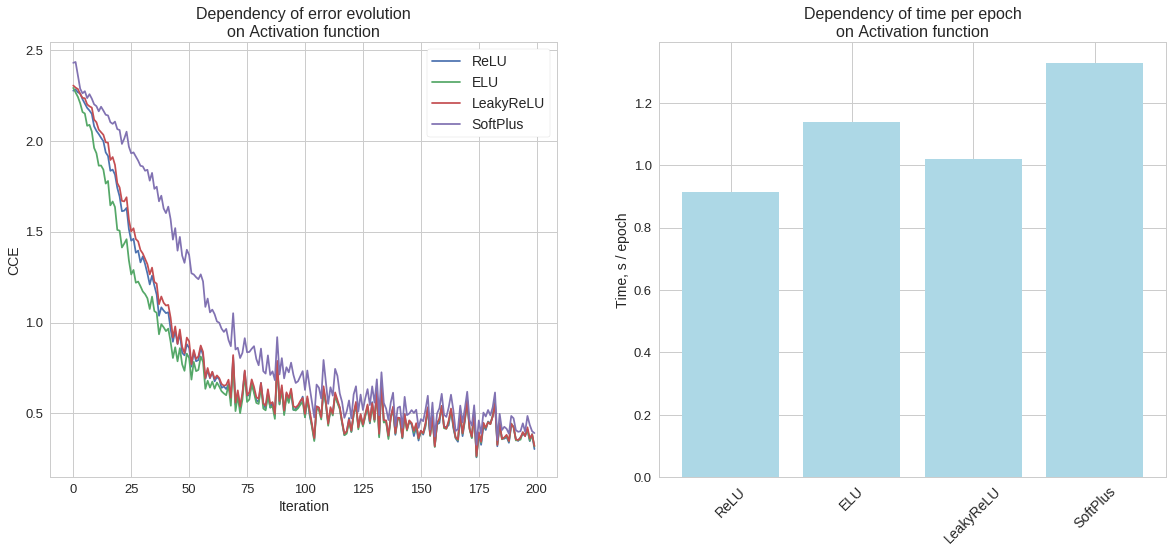

In [23]:
plt.figure(figsize=(20, 8))

plt.subplot(121)
for i in range(len(losses)):
    plt.plot(losses[i][:200], label=names[i])
plt.legend(fontsize=14)
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("CCE", fontsize=14)
plt.title("Dependency of error evolution\non Activation function", fontsize=16)
plt.grid("on")

plt.subplot(122)
plt.bar(np.arange(len(times)), times / 5., color="lightblue")
plt.gca().set_xticks(np.arange(len(times)))
plt.gca().set_xticklabels(names, rotation=45., fontsize=14)
plt.ylabel("Time, s / epoch", fontsize=14)
plt.title("Dependency of time per epoch\non Activation function", fontsize=16)
plt.grid("on")
plt.gca().set_axisbelow(True)

plt.show()

### Opinion on Activations

`ELU` and `SoftPlus` require exponent function computations thus take more time to evaluate. While `ReLU` and `LeakyReLU` need only simple maximum or multiplications thus run faster.

One of the problems with `ReLU` is so called *dead neuron*. It happens when all the inputs give zero activations. In this case the gradient coming from the downstream won't be pushed upwards because it will be multiplied by matrix of zeros. Thus the weights for this neuron won't be updated. To avoid this problem it's better to use not *zero* gradient in the negative halfplane but *small positive gradient*. This is the basic idea behind `LeakyReLU` - leaky here means that even if all the inputs are negative then the part of the gradient will *leak* upstream anyway. The same intuition stands behind `ELU` but in that case the derivative is not constant and put less weight on big megative numbers. 

In my opinion `ELU` (or maybe `LeakyReLU`) is the best option.

## TASK 4: BatchMeanSubtraction
Try to insert `BatchMeanSubtraction` layer between `Linear` module and activation functions.

Plot the losses with and without `BatchMeanSubtraction` on one graph.

Describe what you observe. Does BatchMeanSubtraction help? Why/why not?

No Batch Normalization

In [24]:
net = ModelTorch()
net.add(Linear(X.shape[1], 64))
net.add(ELU())
net.add(Linear(64, y.shape[1]))
net.add(SoftMax())
net.compile(ClassNLLCriterion(), nesterov, {"learning_rate": 0.05, "momentum": 0.6})
np.random.seed(21)
hist_no_BN = net.fit(X, y, iteration_hist=True, epochs=5)

1 Epoch    100% (70000 of 70000) |##############################|	Time: 0:00:01
2 Epoch    100% (70000 of 70000) |##############################|	Time: 0:00:01
3 Epoch    100% (70000 of 70000) |##############################|	Time: 0:00:01
4 Epoch    100% (70000 of 70000) |##############################|	Time: 0:00:01
5 Epoch    100% (70000 of 70000) |##############################|	Time: 0:00:01


Batch Mean Subtraction

In [25]:
net = ModelTorch()
net.add(Linear(X.shape[1], 64))
net.add(BatchMeanSubtraction())
net.add(ELU())
net.add(Linear(64, y.shape[1]))
net.add(SoftMax())
net.compile(ClassNLLCriterion(), nesterov, {"learning_rate": 0.05, "momentum": 0.6}, accuracy=True)
np.random.seed(21)
hist_BN = net.fit(X, y, iteration_hist=True, epochs=5)

1 Epoch    100% (70000 of 70000) |##############################|	Time: 0:00:01
2 Epoch    100% (70000 of 70000) |##############################|	Time: 0:00:01
3 Epoch    100% (70000 of 70000) |##############################|	Time: 0:00:01
4 Epoch    100% (70000 of 70000) |##############################|	Time: 0:00:01
5 Epoch    100% (70000 of 70000) |##############################|	Time: 0:00:01


In [26]:
losses = np.array([hist_no_BN["loss"], hist_BN["loss"]])
times = np.array([hist_no_BN["time"], hist_BN["time"]])
names = ["No BN", "BN"]

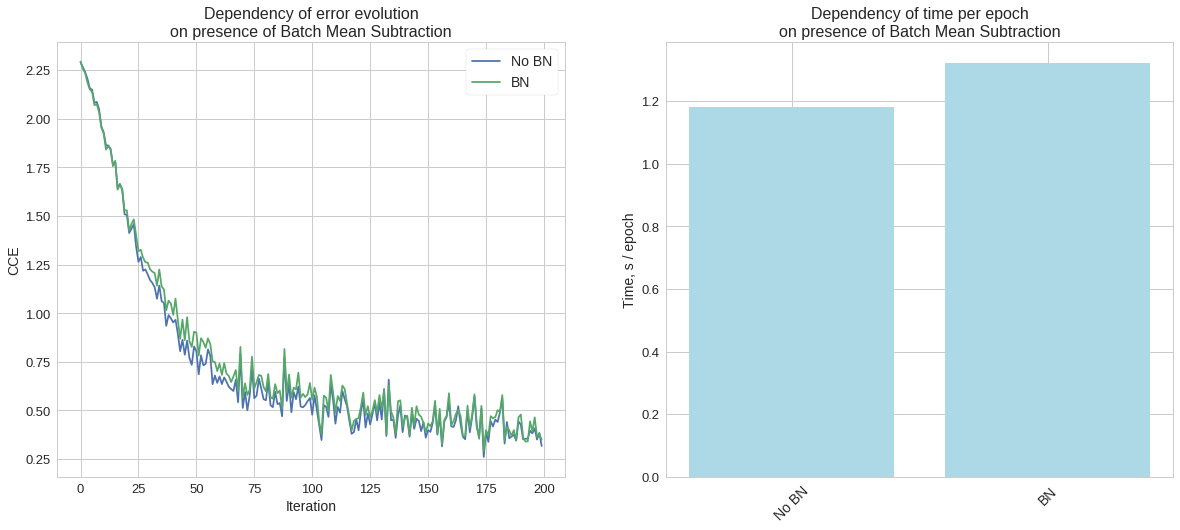

In [27]:
plt.figure(figsize=(20, 8))

plt.subplot(121)
for i in range(len(losses)):
    plt.plot(losses[i][:200], label=names[i])
plt.legend(fontsize=14)
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("CCE", fontsize=14)
plt.title("Dependency of error evolution\non presence of Batch Mean Subtraction", fontsize=16)
plt.grid("on")

plt.subplot(122)
plt.bar(np.arange(len(times)), times / 5., color="lightblue")
plt.gca().set_xticks(np.arange(len(times)))
plt.gca().set_xticklabels(names, rotation=45., fontsize=14)
plt.ylabel("Time, s / epoch", fontsize=14)
plt.title("Dependency of time per epoch\non presence of Batch Mean Subtraction", fontsize=16)
plt.grid("on")
plt.gca().set_axisbelow(True)

plt.show()

### Opinion on BN

Does `BatchMeanSubtraction` help?

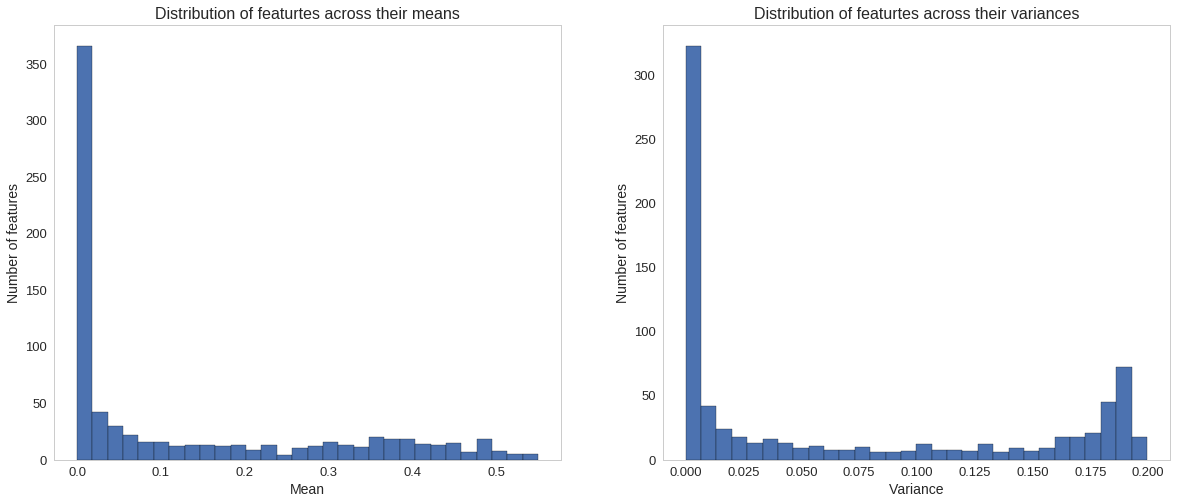

In [28]:
plt.figure(figsize=(20, 8))

plt.subplot(121)
plt.hist(np.mean(X, axis=0), bins=30, edgecolor="k")
plt.grid()
plt.gca().set_axisbelow(True)
plt.xlabel("Mean", fontsize=14)
plt.ylabel("Number of features", fontsize=14)
plt.title("Distribution of featurtes across their means", fontsize=16)

plt.subplot(122)
plt.hist(np.var(X, axis=0), bins=30, edgecolor="k")
plt.grid()
plt.gca().set_axisbelow(True)
plt.xlabel("Variance", fontsize=14)
plt.ylabel("Number of features", fontsize=14)
plt.title("Distribution of featurtes across their variances", fontsize=16)

plt.show()

In case of `MNIST` dataset the mean value of almost all the features are zero (pixels near the boreders that almost never contain any drawings). Recall also that we did feature normalization to the range $[0;1]$ before. Thus we can not have features with values more than $1$.

In a nutshell, as one can notice from a graph mean values of features are near zero even without `BatchMeanSubtraction` layer. Thus it does not help in this particular case.

One thing here thar can be improved is to implement variance normalization also because as one can notice variance is far away from $1$.

## TASK 5: Optimization methods

Compare available optimization methods for the best architecture you have found previously.

What optimization method was the best for you?

In [29]:
optimizers = [sgd_momentum, nesterov, adam]
optimizer_config = {"learning_rate": 0.001, "momentum": 0.9, "beta1": 0.9}

In [30]:
nets = []
hists = []
for opt in optimizers:
    net = ModelTorch()
    net.add(Linear(X.shape[1], 64))
    net.add(ELU())
    net.add(Linear(64, y.shape[1]))
    net.add(SoftMax())
    net.compile(ClassNLLCriterion(), opt, optimizer_config, accuracy=True)
    
    print(opt.__name__)
    sys.stdout.flush()
    np.random.seed(21)
    hist = net.fit(X, y, iteration_hist=True, epochs=5)
    print("")
    
    nets.append(net)
    hists.append(hist)

sgd_momentum


1 Epoch    100% (70000 of 70000) |##############################|	Time: 0:00:01
2 Epoch    100% (70000 of 70000) |##############################|	Time: 0:00:01
3 Epoch    100% (70000 of 70000) |##############################|	Time: 0:00:01
4 Epoch    100% (70000 of 70000) |##############################|	Time: 0:00:01
5 Epoch    100% (70000 of 70000) |##############################|	Time: 0:00:01



nesterov


1 Epoch    100% (70000 of 70000) |##############################|	Time: 0:00:01
2 Epoch    100% (70000 of 70000) |##############################|	Time: 0:00:01
3 Epoch    100% (70000 of 70000) |##############################|	Time: 0:00:01
4 Epoch    100% (70000 of 70000) |##############################|	Time: 0:00:01
5 Epoch    100% (70000 of 70000) |##############################|	Time: 0:00:01



adam


1 Epoch    100% (70000 of 70000) |##############################|	Time: 0:00:01
2 Epoch    100% (70000 of 70000) |##############################|	Time: 0:00:01
3 Epoch    100% (70000 of 70000) |##############################|	Time: 0:00:01
4 Epoch    100% (70000 of 70000) |##############################|	Time: 0:00:01
5 Epoch    100% (70000 of 70000) |##############################|	Time: 0:00:01


In [31]:
losses = np.array(list(map(lambda x: x["loss"], hists)))
times = np.array(list(map(lambda x: x["time"], hists)))
names = list(map(lambda x: x.__name__, optimizers))

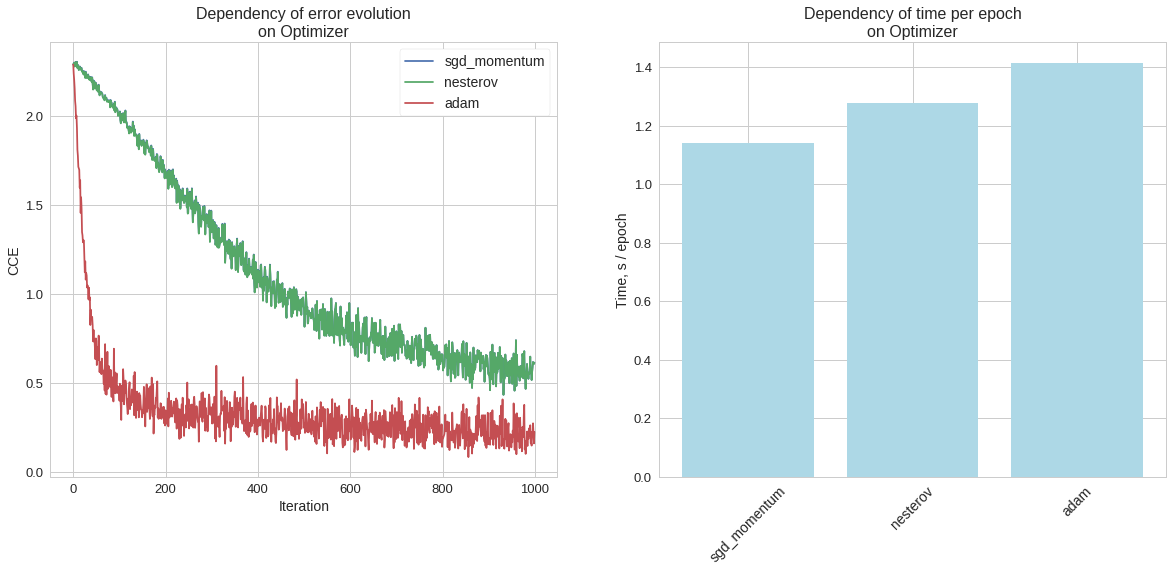

In [32]:
plt.figure(figsize=(20, 8))

plt.subplot(121)
for i in range(len(losses)):
    plt.plot(losses[i][:1000], label=names[i])
plt.legend(fontsize=14)
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("CCE", fontsize=14)
plt.title("Dependency of error evolution\non Optimizer", fontsize=16)
plt.grid("on")

plt.subplot(122)
plt.bar(np.arange(len(times)), times / 5., color="lightblue")
plt.gca().set_xticks(np.arange(len(times)))
plt.gca().set_xticklabels(names, rotation=45., fontsize=14)
plt.ylabel("Time, s / epoch", fontsize=14)
plt.title("Dependency of time per epoch\non Optimizer", fontsize=16)
plt.grid("on")
plt.gca().set_axisbelow(True)

plt.show()

### Opinion on Optimizers

Not surprisingly, `Adam` worked the best. In my opinion it is due to the fact that `Adam` uses both momentum method and adaptive learning rate (different per each direction). One way to improve it is to use Nesterov momentum instead of usual Polyak momentum. This method is called `Nadam`.